## Libraly and package

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize,MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/hello_tlu')
import Fx
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/hello_tlu/Tokyo_eurusd.csv')
data

,Position_MACD,Position_AO,Position_RSI,trend_1h,trend_4h,trend_8h,trend_day,trend_week,trend_month,Datetime,Close,label
0,0,0,1,0.000259,0.002720,0.001622,-0.003664,-0.018713,-0.030232,2010-02-01 06:00:00,1.38961,0.0
1,0,0,1,0.000079,0.001629,0.000483,-0.003929,-0.017949,-0.030146,2010-02-01 06:15:00,1.38920,0.0
2,0,0,1,-0.000778,0.000029,-0.000396,-0.005069,-0.018497,-0.031539,2010-02-01 06:30:00,1.38763,0.0
3,0,0,1,0.000908,0.001045,0.001709,-0.004863,-0.018049,-0.029374,2010-02-01 06:45:00,1.38948,0.0
4,0,0,1,-0.000201,0.001175,0.001110,-0.004471,-0.016779,-0.027754,2010-02-01 07:00:00,1.38933,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
147817,-1,0,-1,0.000251,0.000623,0.000483,0.003055,0.005199,-0.006018,2024-05-06 01:45:00,1.07690,0.0
147818,-1,0,-1,0.000139,0.000511,0.000307,0.002971,0.005012,-0.006386,2024-05-06 02:00:00,1.07677,0.0
147819,-1,0,-1,0.000399,0.000604,0.000390,0.003364,0.004993,-0.006257,2024-05-06 02:15:00,1.07687,0.0
147820,-1,0,-1,0.000195,0.000493,0.000111,0.003168,0.004563,-0.006771,2024-05-06 02:30:00,1.07665,0.0


# Use RNN

## DATA LOADER

In [4]:

class PricePredictionDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        self.features = data.iloc[:, :-3].values
        self.labels = data.iloc[:, -1].values

        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.labels[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Chuyển đổi cột thời gian
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Chia dữ liệu thành các tập train, validation, test
train_data = data[(data['Datetime'] >= '2010-01-01') & (data['Datetime'] < '2017-01-01')]
val_data = data[(data['Datetime'] >= '2017-01-01') & (data['Datetime'] < '2020-01-01')]
test_data = data[(data['Datetime'] >= '2020-01-01') & (data['Datetime'] < '2024-01-01')]
test_data_2 = data[(data['Datetime'] >= '2024-01-01')]

SEQ_LENGTH = 60

train_dataset = PricePredictionDataset(train_data, SEQ_LENGTH)
val_dataset = PricePredictionDataset(val_data, SEQ_LENGTH)
test_dataset = PricePredictionDataset(test_data, SEQ_LENGTH)
test_dataset_2 = PricePredictionDataset(test_data_2, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=64, shuffle=False)

print("Kích thước tập train:", len(train_data), len(train_dataset))
print("Kích thước tập validation:", len(val_data), len(val_dataset))
print("Kích thước tập test 1:", len(test_data), len(test_dataset))
print("Kích thước tập test 2:", len(test_data_2), len(test_dataset_2))


Kích thước tập train: 71711 71651
Kích thước tập validation: 31031 30971
Kích thước tập test 1: 41508 41448
Kích thước tập test 2: 3572 3512


## Khai báo model, train

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = train_dataset.features.shape[1]
hidden_size = 50
output_size = 1
num_layers = 2

model = RNNModel(input_size, hidden_size, output_size, num_layers)


In [7]:

learning_rate = 0.001
num_epochs = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')


Epoch [1/20], Train Loss: 0.3758, Val Loss: 0.3561
Epoch [2/20], Train Loss: 0.3900, Val Loss: 0.3610
Epoch [3/20], Train Loss: 0.4114, Val Loss: 0.3828
Epoch [4/20], Train Loss: 0.4102, Val Loss: 0.3732
Epoch [5/20], Train Loss: 0.4326, Val Loss: 0.4042
Epoch [6/20], Train Loss: 0.3901, Val Loss: 0.3723
Epoch [7/20], Train Loss: 0.4119, Val Loss: 0.3758
Epoch [8/20], Train Loss: 0.3802, Val Loss: 0.3645
Epoch [9/20], Train Loss: 0.4411, Val Loss: 0.3859
Epoch [10/20], Train Loss: 0.4286, Val Loss: 0.3717
Epoch [11/20], Train Loss: 0.4228, Val Loss: 0.3652
Epoch [12/20], Train Loss: 0.4260, Val Loss: 0.3827
Epoch [13/20], Train Loss: 0.4202, Val Loss: 0.3729
Epoch [14/20], Train Loss: 0.4104, Val Loss: 0.3878
Epoch [15/20], Train Loss: 0.4469, Val Loss: 0.3891
Epoch [16/20], Train Loss: 0.4465, Val Loss: 0.3926
Epoch [17/20], Train Loss: 0.3901, Val Loss: 0.3560
Epoch [18/20], Train Loss: 0.4491, Val Loss: 0.3957
Epoch [19/20], Train Loss: 0.4336, Val Loss: 0.3890
Epoch [20/20], Train 

## Test

In [8]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}')


Test Loss: 0.3667


In [9]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)




In [10]:

def convert_to_classes(predictions, threshold_positive, threshold_negative):
    classes = np.zeros_like(predictions)
    classes[predictions > threshold_positive] = 1
    classes[predictions < threshold_negative] = -1
    return classes

# Lưu trữ kết quả
results = []

# Vòng lặp qua các ngưỡng từ 0 đến 1 với bước nhảy là 0.1
for threshold_positive in np.arange(0, 1, 0.1):
    for threshold_negative in np.arange(-1, 0, 0.1):

        predicted_classes = convert_to_classes(predictions, threshold_positive, threshold_negative)

        f1 = f1_score(actuals, predicted_classes, average='macro')
        precision = precision_score(actuals, predicted_classes, average='macro')
        recall = recall_score(actuals, predicted_classes, average='macro')
        accuracy = accuracy_score(actuals, predicted_classes)

        results.append({
            'threshold_positive': threshold_positive,
            'threshold_negative': threshold_negative,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })

# # In kết quả
for result in results:
    print(f"Thresholds: +{result['threshold_positive']}, -{result['threshold_negative']} -> "
          f"F1 Score: {result['f1_score']:.4f}, Precision: {result['precision']:.4f}, "
          f"Recall: {result['recall']:.4f}, Accuracy: {result['accuracy']:.4f}")


Thresholds: +0.0, --1.0 -> F1 Score: 0.3277, Precision: 0.3063, Recall: 0.3618, Accuracy: 0.5836
Thresholds: +0.0, --0.9 -> F1 Score: 0.3277, Precision: 0.3063, Recall: 0.3618, Accuracy: 0.5836
Thresholds: +0.0, --0.8 -> F1 Score: 0.3277, Precision: 0.3063, Recall: 0.3618, Accuracy: 0.5836
Thresholds: +0.0, --0.7000000000000001 -> F1 Score: 0.3278, Precision: 0.4730, Recall: 0.3619, Accuracy: 0.5836
Thresholds: +0.0, --0.6000000000000001 -> F1 Score: 0.3292, Precision: 0.4882, Recall: 0.3624, Accuracy: 0.5837
Thresholds: +0.0, --0.5000000000000001 -> F1 Score: 0.3328, Precision: 0.4643, Recall: 0.3637, Accuracy: 0.5835
Thresholds: +0.0, --0.40000000000000013 -> F1 Score: 0.3422, Precision: 0.4258, Recall: 0.3662, Accuracy: 0.5805
Thresholds: +0.0, --0.30000000000000016 -> F1 Score: 0.3787, Precision: 0.4158, Recall: 0.3803, Accuracy: 0.5646
Thresholds: +0.0, --0.20000000000000018 -> F1 Score: 0.3918, Precision: 0.3978, Recall: 0.4138, Accuracy: 0.4619
Thresholds: +0.0, --0.100000000000

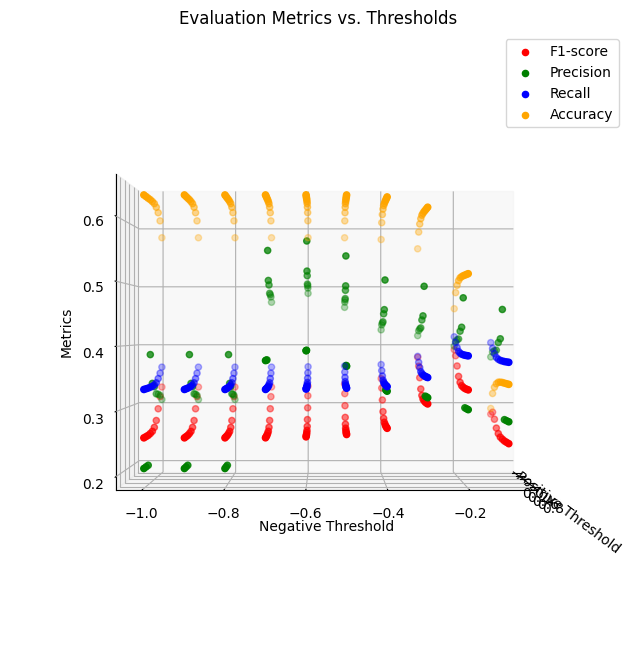

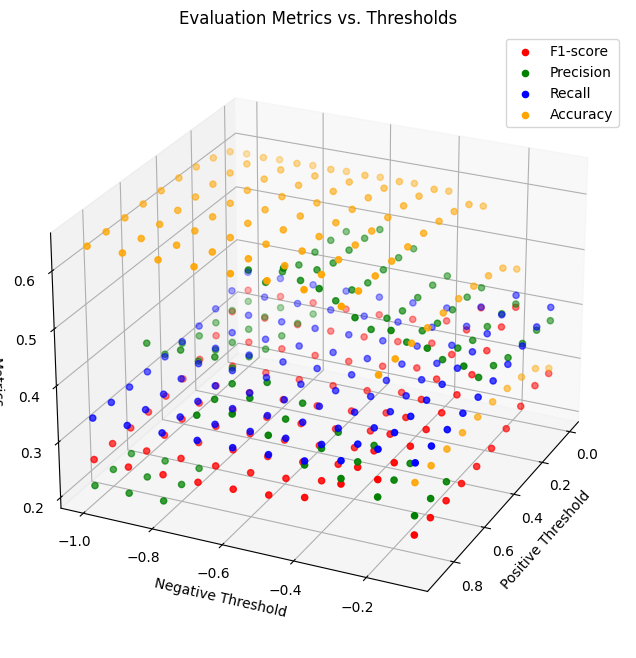

In [11]:

from mpl_toolkits.mplot3d import Axes3D

# Define function to convert predictions to classes
def convert_to_classes(predictions, threshold_positive, threshold_negative):
    classes = np.zeros_like(predictions)
    classes[predictions > threshold_positive] = 1
    classes[predictions < threshold_negative] = -1
    return classes

# Store results
results = []

# Loop through thresholds from 0 to 1 for positive threshold and from -1 to 0 for negative threshold
for threshold_positive in np.arange(0, 1, 0.1):
    for threshold_negative in np.arange(-1, 0, 0.1):

        predicted_classes = convert_to_classes(predictions, threshold_positive, threshold_negative)

        f1 = f1_score(actuals, predicted_classes, average='macro')
        precision = precision_score(actuals, predicted_classes, average='macro')
        recall = recall_score(actuals, predicted_classes, average='macro')
        accuracy = accuracy_score(actuals, predicted_classes)

        results.append({
            'threshold_positive': threshold_positive,
            'threshold_negative': threshold_negative,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })

# Extract metrics from results
thresholds_positive = [result['threshold_positive'] for result in results]
thresholds_negative = [result['threshold_negative'] for result in results]
f1_scores = [result['f1_score'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
accuracies = [result['accuracy'] for result in results]

# Plot metrics
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thresholds_positive, thresholds_negative, f1_scores, c='r', label='F1-score', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, precisions, c='g', label='Precision', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, recalls, c='b', label='Recall', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, accuracies, c='orange', label='Accuracy', marker='o')
ax.set_xlabel('Positive Threshold')
ax.set_ylabel('Negative Threshold')
ax.set_zlabel('Metrics')
ax.set_title('Evaluation Metrics vs. Thresholds')
ax.view_init(elev=0, azim=0)  # Rotate the plot
plt.legend()
plt.show()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thresholds_positive, thresholds_negative, f1_scores, c='r', label='F1-score', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, precisions, c='g', label='Precision', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, recalls, c='b', label='Recall', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, accuracies, c='orange', label='Accuracy', marker='o')
ax.set_xlabel('Positive Threshold')
ax.set_ylabel('Negative Threshold')
ax.set_zlabel('Metrics')
ax.set_title('Evaluation Metrics vs. Thresholds')
ax.view_init(elev=25, azim=25)  # Rotate the plot
plt.legend()
plt.show()


## Evalu

In [12]:
model.eval()
predictions_2 = []
actuals_2 = []
with torch.no_grad():
    for inputs, targets in test_loader_2:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_2.append(outputs.cpu().numpy())
        actuals_2.append(targets.numpy())

predictions_2 = np.concatenate(predictions_2)
actuals_2 = np.concatenate(actuals_2)





In [13]:
threshold_positive=0.6
threshold_negative=-0.6

predicted_classes_2 = convert_to_classes(predictions_2, threshold_positive, threshold_negative)

f1 = f1_score(actuals_2, predicted_classes_2, average='macro')
precision = precision_score(actuals_2, predicted_classes_2, average='macro')
recall = recall_score(actuals_2, predicted_classes_2, average='macro')
accuracy = accuracy_score(actuals_2, predicted_classes_2)

print(f'threshold_positive: {threshold_positive}   threshold_negative: {threshold_negative}    f1_score: {f1}    precision: {precision}    recall: {recall}    accuracy: {accuracy}')



threshold_positive: 0.6   threshold_negative: -0.6    f1_score: 0.2747779253908984    precision: 0.5265193472831878    recall: 0.34030363579787487    accuracy: 0.6195899772209568


Margin: -0.006761987627357677
MDD: 0.11938245503532793

   Total trading quantity: 3898
 Trading quantity per day: 3.751684311838306
          Return per year: 0.0013024586628397766
                  HitRate: 0.4022575679835813
          HitRate per day: 0.4662813102119461


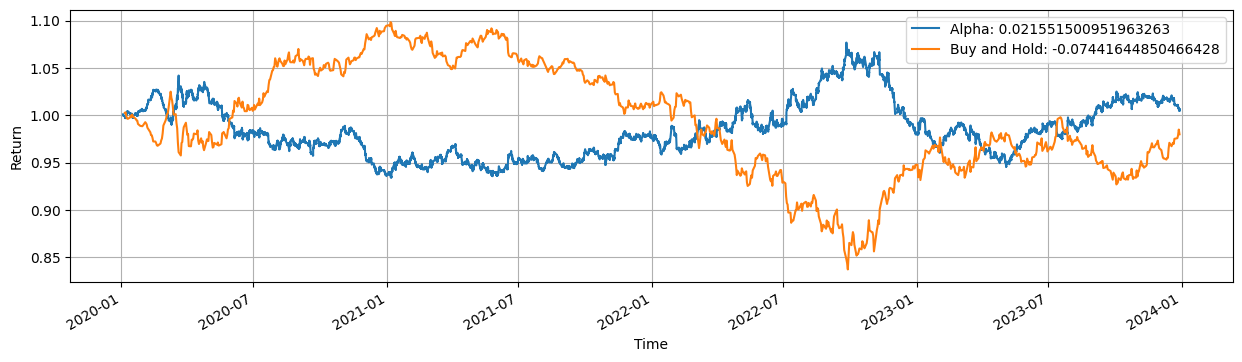

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-02 08:00:00,0,0.0,0.0,NaN,NaN,NaN
2020-01-03 08:00:00,0.0,0.0,0.0,-1.0,1.11468,NaN
2020-01-03 08:15:00,-0.00001,0.0,-0.00001,-1.0,1.11469,0.999991
2020-01-03 08:30:00,0.00017,0.0,0.00017,-1.0,1.11451,1.000153
2020-01-03 08:45:00,0.00068,0.0,0.00068,-1.0,1.11400,1.000610
...,...,...,...,...,...,...
2023-12-29 08:45:00,-0.00584,0.0,-0.00584,-1.0,1.10594,1.005307
2023-12-29 09:00:00,-0.00535,0.0,-0.00535,-1.0,1.10545,1.005750
2023-12-29 09:15:00,-0.00497,0.0,-0.00497,-1.0,1.10507,1.006094


In [14]:
tdt=test_data.reset_index(drop=True).loc[60:,:].reset_index(drop=True)
tdt['Predict'] = pd.Series(predicted_classes.flatten())
backTestInfo = Fx.BacktestInformation(tdt['Datetime'], tdt['Predict'],tdt['Close'],fee=0)
backTestInfo.Plot_PNL()


Margin: -0.47449688035298976
MDD: 0.004916726260899047

   Total trading quantity: 34
 Trading quantity per day: 0.38202247191011235
          Return per year: -0.00915006365887938
                  HitRate: 0.4117647058823529
          HitRate per day: 0.14772727272727273


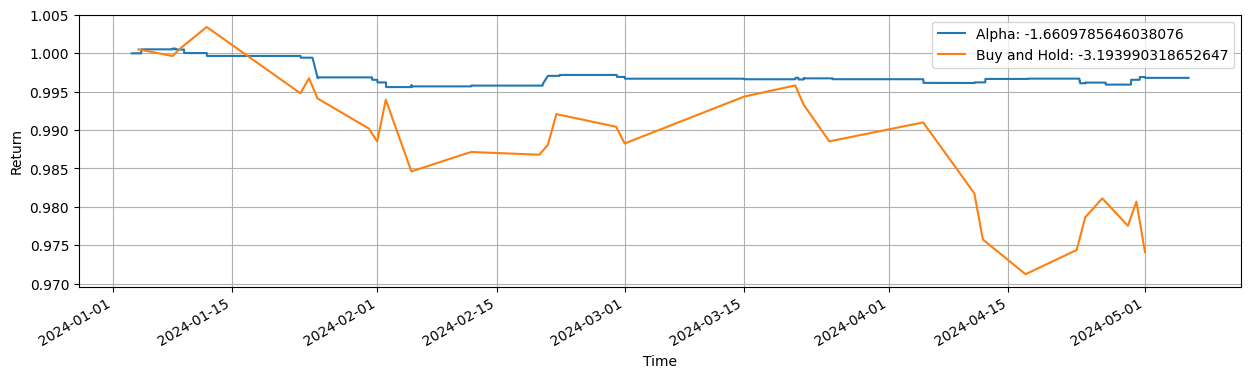

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2024-01-03 05:00:00,0.00000,0.0,0.00000,0.0,1.09599,NaN
2024-01-03 05:15:00,0.00000,0.0,0.00000,0.0,1.09577,1.000000
2024-01-03 05:30:00,0.00000,0.0,0.00000,0.0,1.09558,1.000000
2024-01-03 05:45:00,0.00000,0.0,0.00000,0.0,1.09502,1.000000
2024-01-03 06:00:00,0.00000,0.0,0.00000,0.0,1.09555,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,-0.00349,0.0,-0.00349,0.0,1.07690,0.996805
2024-05-06 02:00:00,-0.00349,0.0,-0.00349,0.0,1.07677,0.996805
2024-05-06 02:15:00,-0.00349,0.0,-0.00349,0.0,1.07687,0.996805


In [15]:
tdt=test_data_2.reset_index(drop=True).loc[60:,:].reset_index(drop=True)
tdt['Predict'] = pd.Series(predicted_classes_2.flatten())
backTestInfo = Fx.BacktestInformation(tdt['Datetime'], tdt['Predict'],tdt['Close'],fee=0)
backTestInfo.Plot_PNL()

In [16]:
file_path = '/content/drive/MyDrive/hello_tlu/rnn_model.pth'
torch.save({
            'model_state_dict': model.state_dict(),
            }, file_path)

# USE LSTM

## Load data

In [ ]:


class PricePredictionDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        self.features = data.iloc[:, :-3].values
        self.labels = data.iloc[:, -1].values

        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.labels[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

data = pd.read_csv('/content/drive/MyDrive/hello_tlu/Tokyo_eurusd.csv')

# Chuyển đổi cột thời gian
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Chia dữ liệu thành các tập train, validation, test
train_data = data[(data['Datetime'] >= '2010-01-01') & (data['Datetime'] < '2017-01-01')]
val_data = data[(data['Datetime'] >= '2017-01-01') & (data['Datetime'] < '2020-01-01')]
test_data = data[(data['Datetime'] >= '2020-01-01') & (data['Datetime'] < '2024-01-01')]
test_data_2 = data[(data['Datetime'] >= '2024-01-01')]

SEQ_LENGTH = 60

train_dataset = PricePredictionDataset(train_data, SEQ_LENGTH)
val_dataset = PricePredictionDataset(val_data, SEQ_LENGTH)
test_dataset = PricePredictionDataset(test_data, SEQ_LENGTH)
test_dataset_2 = PricePredictionDataset(test_data_2, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=64, shuffle=False)

print("Kích thước tập train:",len(train_data) ,len(train_dataset))
print("Kích thước tập validation:",len(val_data) ,len(val_dataset))
print("Kích thước tập test 1:",len(test_data) ,len(test_dataset))
print("Kích thước tập test 2:",len(test_data_2) ,len(test_dataset_2))


Kích thước tập train: 71711 71651
Kích thước tập validation: 31031 30971
Kích thước tập test 1: 41508 41448
Kích thước tập test 2: 3572 3512


## Train

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = train_dataset.features.shape[1]
hidden_size = 50
output_size = 1  # Dự đoán vị thế
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [ ]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Tính toán loss trên tập validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/50], Loss: 0.4987, Val Loss: 0.3601
Epoch [2/50], Loss: 0.2982, Val Loss: 0.3606
Epoch [3/50], Loss: 0.2854, Val Loss: 0.3528
Epoch [4/50], Loss: 0.2969, Val Loss: 0.3742
Epoch [5/50], Loss: 0.3488, Val Loss: 0.3618
Epoch [6/50], Loss: 0.2814, Val Loss: 0.3548
Epoch [7/50], Loss: 0.5348, Val Loss: 0.3520
Epoch [8/50], Loss: 0.3894, Val Loss: 0.3605
Epoch [9/50], Loss: 0.3242, Val Loss: 0.3553
Epoch [10/50], Loss: 0.3858, Val Loss: 0.3583
Epoch [11/50], Loss: 0.2905, Val Loss: 0.3625
Epoch [12/50], Loss: 0.3811, Val Loss: 0.3599
Epoch [13/50], Loss: 0.4365, Val Loss: 0.3488
Epoch [14/50], Loss: 0.4051, Val Loss: 0.3571
Epoch [15/50], Loss: 0.3312, Val Loss: 0.3663
Epoch [16/50], Loss: 0.3430, Val Loss: 0.3535
Epoch [17/50], Loss: 0.2812, Val Loss: 0.3551
Epoch [18/50], Loss: 0.3968, Val Loss: 0.3601
Epoch [19/50], Loss: 0.4015, Val Loss: 0.3545
Epoch [20/50], Loss: 0.3526, Val Loss: 0.3630
Epoch [21/50], Loss: 0.3287, Val Loss: 0.3577
Epoch [22/50], Loss: 0.2857, Val Loss: 0.35

## Test evalu

In [ ]:
# Đánh giá mô hình trên tập test
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs.squeeze(), targets).item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.4368


In [ ]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)




In [ ]:

def convert_to_classes(predictions, threshold_positive, threshold_negative):
    classes = np.zeros_like(predictions)
    classes[predictions > threshold_positive] = 1
    classes[predictions < threshold_negative] = -1
    return classes

# Lưu trữ kết quả
results = []

# Vòng lặp qua các ngưỡng từ 0 đến 1 với bước nhảy là 0.1
for threshold_positive in np.arange(0, 1, 0.1):
    for threshold_negative in np.arange(-1, 0, 0.1):

        predicted_classes = convert_to_classes(predictions, threshold_positive, threshold_negative)

        f1 = f1_score(actuals, predicted_classes, average='macro')
        precision = precision_score(actuals, predicted_classes, average='macro')
        recall = recall_score(actuals, predicted_classes, average='macro')
        accuracy = accuracy_score(actuals, predicted_classes)

        results.append({
            'threshold_positive': threshold_positive,
            'threshold_negative': threshold_negative,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })

# # In kết quả
for result in results:
    print(f"Thresholds: +{result['threshold_positive']}, -{result['threshold_negative']} -> "
          f"F1 Score: {result['f1_score']:.4f}, Precision: {result['precision']:.4f}, "
          f"Recall: {result['recall']:.4f}, Accuracy: {result['accuracy']:.4f}")


Thresholds: +0.0, --1.0 -> F1 Score: 0.3044, Precision: 0.3640, Recall: 0.3541, Accuracy: 0.4722
Thresholds: +0.0, --0.9 -> F1 Score: 0.3057, Precision: 0.3551, Recall: 0.3542, Accuracy: 0.4713
Thresholds: +0.0, --0.8 -> F1 Score: 0.3100, Precision: 0.3635, Recall: 0.3551, Accuracy: 0.4693
Thresholds: +0.0, --0.7000000000000001 -> F1 Score: 0.3178, Precision: 0.3604, Recall: 0.3565, Accuracy: 0.4641
Thresholds: +0.0, --0.6000000000000001 -> F1 Score: 0.3307, Precision: 0.3635, Recall: 0.3603, Accuracy: 0.4547
Thresholds: +0.0, --0.5000000000000001 -> F1 Score: 0.3441, Precision: 0.3647, Recall: 0.3661, Accuracy: 0.4372
Thresholds: +0.0, --0.40000000000000013 -> F1 Score: 0.3459, Precision: 0.3596, Recall: 0.3695, Accuracy: 0.4068
Thresholds: +0.0, --0.30000000000000016 -> F1 Score: 0.3381, Precision: 0.3584, Recall: 0.3756, Accuracy: 0.3684
Thresholds: +0.0, --0.20000000000000018 -> F1 Score: 0.3105, Precision: 0.3545, Recall: 0.3774, Accuracy: 0.3171
Thresholds: +0.0, --0.100000000000

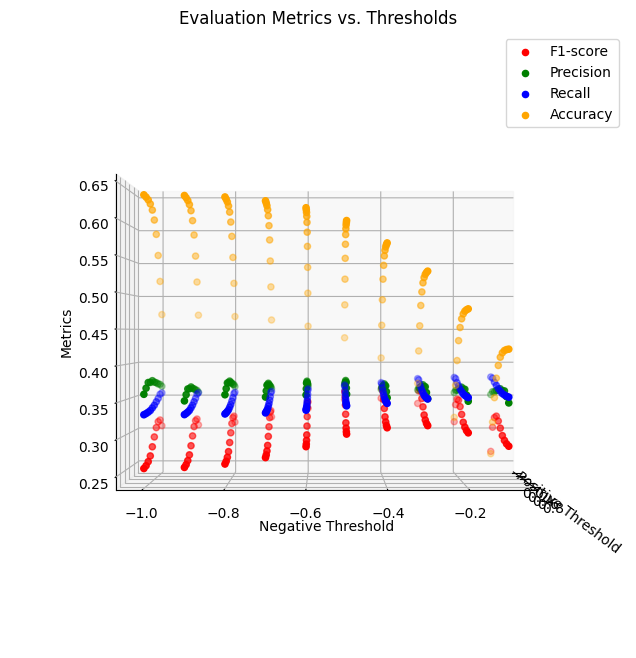

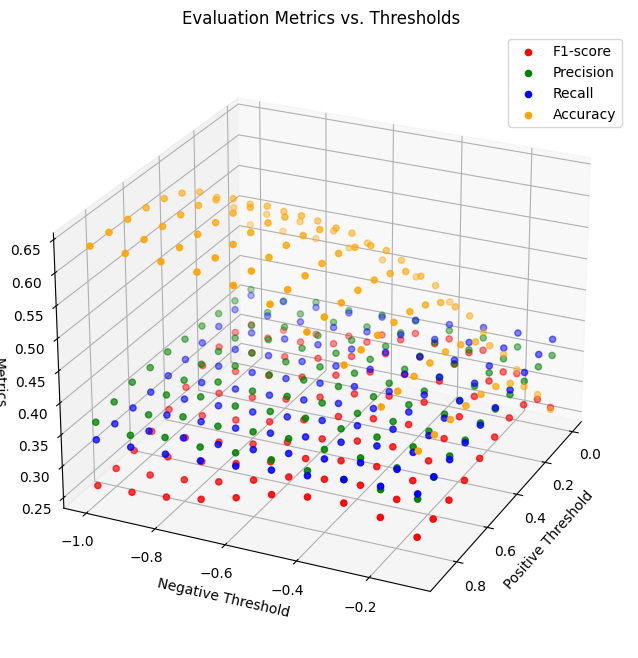

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

# Define function to convert predictions to classes
def convert_to_classes(predictions, threshold_positive, threshold_negative):
    classes = np.zeros_like(predictions)
    classes[predictions > threshold_positive] = 1
    classes[predictions < threshold_negative] = -1
    return classes

# Store results
results = []

# Loop through thresholds from 0 to 1 for positive threshold and from -1 to 0 for negative threshold
for threshold_positive in np.arange(0, 1, 0.1):
    for threshold_negative in np.arange(-1, 0, 0.1):

        predicted_classes = convert_to_classes(predictions, threshold_positive, threshold_negative)

        f1 = f1_score(actuals, predicted_classes, average='macro')
        precision = precision_score(actuals, predicted_classes, average='macro')
        recall = recall_score(actuals, predicted_classes, average='macro')
        accuracy = accuracy_score(actuals, predicted_classes)

        results.append({
            'threshold_positive': threshold_positive,
            'threshold_negative': threshold_negative,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })

# Extract metrics from results
thresholds_positive = [result['threshold_positive'] for result in results]
thresholds_negative = [result['threshold_negative'] for result in results]
f1_scores = [result['f1_score'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
accuracies = [result['accuracy'] for result in results]

# Plot metrics
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thresholds_positive, thresholds_negative, f1_scores, c='r', label='F1-score', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, precisions, c='g', label='Precision', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, recalls, c='b', label='Recall', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, accuracies, c='orange', label='Accuracy', marker='o')
ax.set_xlabel('Positive Threshold')
ax.set_ylabel('Negative Threshold')
ax.set_zlabel('Metrics')
ax.set_title('Evaluation Metrics vs. Thresholds')
ax.view_init(elev=0, azim=0)  # Rotate the plot
plt.legend()
plt.show()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thresholds_positive, thresholds_negative, f1_scores, c='r', label='F1-score', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, precisions, c='g', label='Precision', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, recalls, c='b', label='Recall', marker='o')
ax.scatter(thresholds_positive, thresholds_negative, accuracies, c='orange', label='Accuracy', marker='o')
ax.set_xlabel('Positive Threshold')
ax.set_ylabel('Negative Threshold')
ax.set_zlabel('Metrics')
ax.set_title('Evaluation Metrics vs. Thresholds')
ax.view_init(elev=25, azim=25)  # Rotate the plot
plt.legend()
plt.show()


In [ ]:
model.eval()
predictions_2 = []
actuals_2 = []
with torch.no_grad():
    for inputs, targets in test_loader_2:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_2.append(outputs.cpu().numpy())
        actuals_2.append(targets.numpy())

predictions_2 = np.concatenate(predictions_2)
actuals_2 = np.concatenate(actuals_2)





In [ ]:
threshold_positive=0.6
threshold_negative=-0.7

predicted_classes_2 = convert_to_classes(predictions_2, threshold_positive, threshold_negative)

f1 = f1_score(actuals_2, predicted_classes_2, average='macro')
precision = precision_score(actuals_2, predicted_classes_2, average='macro')
recall = recall_score(actuals_2, predicted_classes_2, average='macro')
accuracy = accuracy_score(actuals_2, predicted_classes_2)

print(f'threshold_positive: {threshold_positive}   threshold_negative: {threshold_negative}    f1_score: {f1}    precision: {precision}    recall: {recall}    accuracy: {accuracy}')



threshold_positive: 0.6   threshold_negative: -0.7    f1_score: 0.3011116407221472    precision: 0.39380849593099443    recall: 0.34356973298977717    accuracy: 0.6005125284738041


Margin: -0.04112355140167058
MDD: 0.13231711320998285

   Total trading quantity: 4440
 Trading quantity per day: 4.273339749759384
          Return per year: -0.0076941378624067755
                  HitRate: 0.4596846846846847
          HitRate per day: 0.4614643545279383


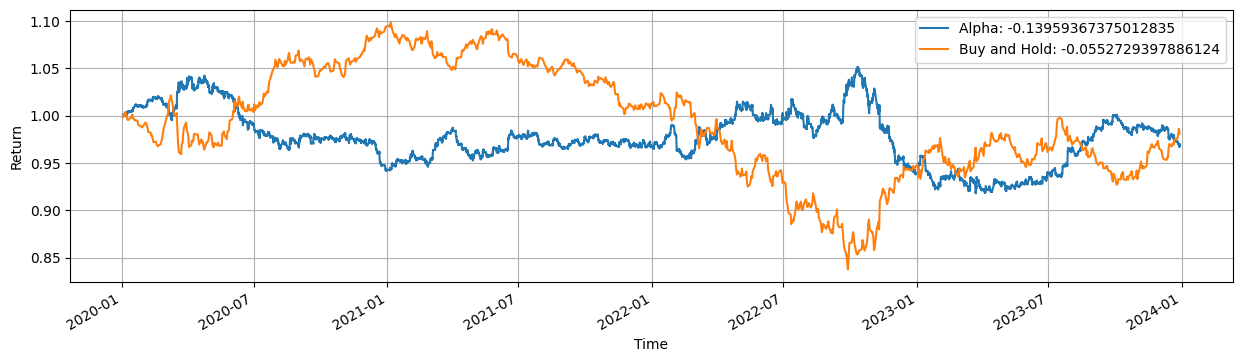

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-01-02 08:00:00,0,0.0,0.0,NaN,NaN,NaN
2020-01-03 08:00:00,0.0,0.0,0.0,-1.0,1.11468,NaN
2020-01-03 08:15:00,-0.00001,0.0,-0.00001,-1.0,1.11469,0.999991
2020-01-03 08:30:00,0.00017,0.0,0.00017,-1.0,1.11451,1.000153
2020-01-03 08:45:00,0.00068,0.0,0.00068,-1.0,1.11400,1.000610
...,...,...,...,...,...,...
2023-12-29 08:45:00,-0.0392,0.0,-0.0392,-1.0,1.10594,0.968662
2023-12-29 09:00:00,-0.03871,0.0,-0.03871,-1.0,1.10545,0.969106
2023-12-29 09:15:00,-0.03833,0.0,-0.03833,-1.0,1.10507,0.969450


In [ ]:
predicted_series = pd.Series(predicted_classes.flatten())
tdt=test_data.reset_index(drop=True).loc[60:,:].reset_index(drop=True)
backTestInfo = Fx.BacktestInformation(tdt['Datetime'], predicted_series,tdt['Close'],fee=0)
backTestInfo.Plot_PNL()


Margin: 0.5088463152504512
MDD: 0.0015949580575420814

   Total trading quantity: 126
 Trading quantity per day: 1.4157303370786516
          Return per year: 0.036760927290007336
                  HitRate: 0.5555555555555556
          HitRate per day: 0.45454545454545453


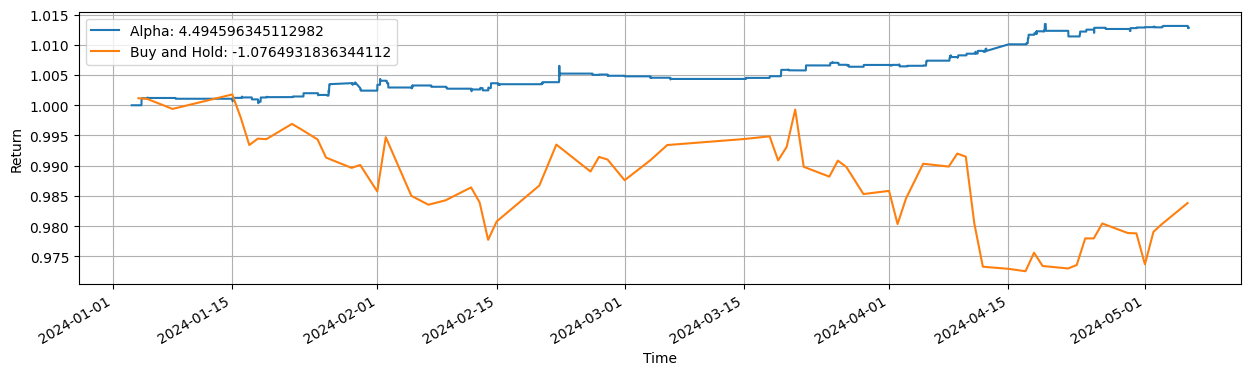

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2024-01-03 05:00:00,0.00000,0.0,0.00000,0.0,1.09599,NaN
2024-01-03 05:15:00,0.00000,0.0,0.00000,0.0,1.09577,1.000000
2024-01-03 05:30:00,0.00000,0.0,0.00000,0.0,1.09558,1.000000
2024-01-03 05:45:00,0.00000,0.0,0.00000,0.0,1.09502,1.000000
2024-01-03 06:00:00,0.00000,0.0,0.00000,0.0,1.09555,1.000000
...,...,...,...,...,...,...
2024-05-06 01:45:00,0.01387,0.0,0.01387,1.0,1.07690,1.012865
2024-05-06 02:00:00,0.01374,0.0,0.01374,1.0,1.07677,1.012744
2024-05-06 02:15:00,0.01384,0.0,0.01384,0.0,1.07687,1.012837


In [ ]:
tdt=test_data_2.reset_index(drop=True).loc[60:,:].reset_index(drop=True)
tdt['Predict'] = pd.Series(predicted_classes_2.flatten())
backTestInfo = Fx.BacktestInformation(tdt['Datetime'], tdt['Predict'],tdt['Close'],fee=0)
backTestInfo.Plot_PNL()

In [ ]:
file_path = '/content/drive/MyDrive/hello_tlu/lstm_model.pth'
torch.save({
            'model_state_dict': model.state_dict(),
            }, file_path)

 # Use Transformer

 ## Load

In [ ]:


class PricePredictionDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = data.iloc[:, :-3].values
        self.labels = data.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

train_data = data[(data['Datetime'] >= '2010-01-01') & (data['Datetime'] < '2017-01-01')]
val_data = data[(data['Datetime'] >= '2017-01-01') & (data['Datetime'] < '2020-01-01')]
test_data = data[(data['Datetime'] >= '2020-01-01') & (data['Datetime'] < '2024-01-01')]
test_data_2 = data[(data['Datetime'] >= '2024-01-01')]

print("Kích thước tập train:", len(train_data))
print("Kích thước tập validation:", len(val_data))
print("Kích thước tập test 1:", len(test_data))
print("Kích thước tập test 2:", len(test_data_2))

Kích thước tập train: 71711
Kích thước tập validation: 31031
Kích thước tập test 1: 41508
Kích thước tập test 2: 3572


In [ ]:
train_dataset = PricePredictionDataset(train_data)
val_dataset = PricePredictionDataset(val_data)
test_dataset = PricePredictionDataset(test_data)
test_dataset_2 = PricePredictionDataset(test_data_2)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=64, shuffle=False)

## Train

In [ ]:

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout_prob):
        super(TransformerModel, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(input_size, num_heads, hidden_size, dropout_prob),
            num_layers)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, src):
        src = self.transformer_encoder(src)
        src = self.fc(src)
        return src

# Example usage of data loading and preprocessing
# Assuming train_loader, val_loader, and test_loader are defined elsewhere
input_size = train_dataset.features.shape[1]
output_size = 3  # Thay đổi output_size thành số lượng nhãn
hidden_size = 256
num_layers = 3

# Điều chỉnh num_heads để đảm bảo input_size chia hết cho num_heads
num_heads = 8
while input_size % num_heads != 0:
    num_heads -= 1

dropout_prob = 0.1

model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout_prob)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()   # Chuyển sang CrossEntropyLoss


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Chuyển đổi nhãn từ -1, 0, 1 thành 0, 0.5, 1
def convert_labels_to_0_0_5_1(labels):
    return (labels + 1) / 2

# Chuyển đổi nhãn từ 0, 0.5, 1 về -1, 0, 1
def convert_labels_back(labels):
    return (labels * 2) - 1
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, targets in train_loader:
        optimizer.zero_grad()
        targets = convert_labels_to_0_0_5_1(targets)  # Chuyển đổi nhãn
        outputs = model(data.unsqueeze(1))  # Add a dimension for Transformer input
        loss = criterion(outputs.squeeze(1), targets.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            targets = convert_labels_to_0_0_5_1(targets)  # Chuyển đổi nhãn
            outputs = model(data.unsqueeze(1))
            loss = criterion(outputs.squeeze(1), targets.long())
            total_val_loss += loss.item()
    print(f'Validation Loss: {total_val_loss/len(val_loader)}')



Epoch [1/10], Loss: 0.5022432788953943
Validation Loss: 0.47828909988255847
Epoch [2/10], Loss: 0.48570944630706236
Validation Loss: 0.4776514981518087
Epoch [3/10], Loss: 0.48486216056570214
Validation Loss: 0.47804026373268405
Epoch [4/10], Loss: 0.4845995074877454
Validation Loss: 0.4775871563203556
Epoch [5/10], Loss: 0.48425628816464666
Validation Loss: 0.47818242477387496
Epoch [6/10], Loss: 0.4841386738576387
Validation Loss: 0.47801518114571717
Epoch [7/10], Loss: 0.48410063563288586
Validation Loss: 0.47822355468248584
Epoch [8/10], Loss: 0.4840193092955956
Validation Loss: 0.4785536618576836
Epoch [9/10], Loss: 0.48406327499224605
Validation Loss: 0.4781112097895023
Epoch [10/10], Loss: 0.48405524997919613
Validation Loss: 0.4781290618107491


## Test

Test Loss: 0.4715919137138799
Test 2 Loss: 0.48594544721501215


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.058264224350345784
Precision: 0.03454683332366135
Recall: 0.18586778452346536
accuracy: 0.18586778452346536


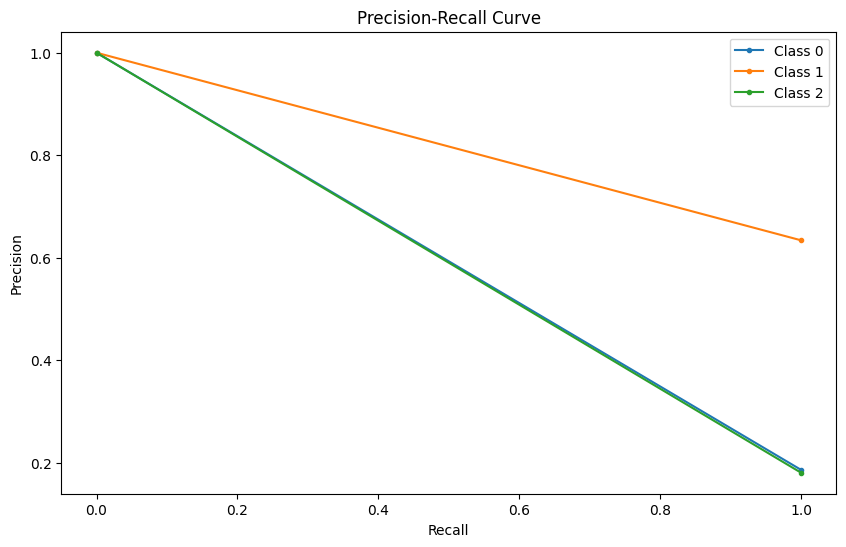

In [ ]:
model.eval()
total_test_loss = 0
actuals = []
predictions = []
with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data.unsqueeze(1))
        loss = criterion(outputs.squeeze(1), convert_labels_to_0_0_5_1(targets).long())  # Chuyển đổi nhãn
        total_test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(torch.argmax(outputs, dim=1).numpy())
print(f'Test Loss: {total_test_loss/len(test_loader)}')

total_test_loss_2 = 0
actuals_2 = []
predictions_2 = []
with torch.no_grad():
    for data, targets in test_loader_2:
        outputs = model(data.unsqueeze(1))
        loss = criterion(outputs.squeeze(1), convert_labels_to_0_0_5_1(targets).long())  # Chuyển đổi nhãn
        total_test_loss_2 += loss.item()
        actuals_2.extend(targets.numpy())
        predictions_2.extend(torch.argmax(outputs, dim=1).numpy())
print(f'Test 2 Loss: {total_test_loss_2/len(test_loader_2)}')

# Chuyển đổi nhãn dự đoán và nhãn thực từ 0, 0.5, 1 về -1, 0, 1
predicted_labels = convert_labels_back(np.array(predictions))[:,2]
actual_labels = np.array(actuals)

# Tính toán F1 Score, Precision và Recall cho từng lớp
f1 = f1_score(actual_labels, predicted_labels, average='weighted')
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
accuracy= accuracy_score(actual_labels, predicted_labels)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'accuracy: {accuracy}')

# Binarize the labels for multi-class Precision-Recall curve
actual_labels_bin = label_binarize(actual_labels, classes=[-1, 0, 1])
predicted_labels_bin = label_binarize(predicted_labels, classes=[-1, 0, 1])

# Tính toán Precision-Recall curve cho từng lớp
precision_vals = dict()
recall_vals = dict()

for i in range(actual_labels_bin.shape[1]):
    precision_vals[i], recall_vals[i], _ = precision_recall_curve(actual_labels_bin[:, i], predicted_labels_bin[:, i])

# Vẽ Precision-Recall curve cho từng lớp
plt.figure(figsize=(10, 6))
for i in range(actual_labels_bin.shape[1]):
    plt.plot(recall_vals[i], precision_vals[i], marker='.', label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()